In [1]:
%load_ext autoreload
%autoreload 2

In [50]:

import pandas as pd
import sys
sys.path.append('../')
import pathlib
from lib.sample_patches_main import sample_patches, sample_hard_negatives, sample_blob_negatives
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [12]:
annotations = pd.read_json('../resources/ddsm/ddsm_annotations.json', orient='records', lines=True)
print(len(annotations)) # coincide con el número de máscaras

4664


In [13]:
print(annotations.iloc[0])

print(annotations.iloc[0]['mask_id'])

bb  = annotations.iloc[0]['bounding_box']

print(bb)
#print(mask_id.split('/')[-1].replace('.png', ''))

type                                                             MASS
assessment                                                          3
subtlety                                                            3
pathology                                                   MALIGNANT
outline             [[793.3386273398, 793.3386273398, 793.08451503...
bounding_box        [643.9205899036, 648.0270371761, 851.276233692...
breast_malignant                                                 True
image_id             cancers/cancer_13/case4124/D_4124_1.RIGHT_CC.png
mask_id             cancers/cancer_13/case4124/D_4124_1.RIGHT_CC_M...
Name: 0, dtype: object
cancers/cancer_13/case4124/D_4124_1.RIGHT_CC_MASS_MALIGNANT_mask_0.png
[643.9205899036, 648.0270371761, 851.2762336926, 793.378895982, 747.5984117981, 720.702966579, 207.6097560976, 145.5681562148]


In [14]:
def extract_patches_from_anot(annotation, ddsm_root_dir):
    ddsm_root_dir = pathlib.Path(ddsm_root_dir)
    
    image_id = annotation['image_id']
    image_path = ddsm_root_dir / image_id
    img = np.array(Image.open(str(image_path)))
    
    mask_id = annotation['mask_id']
    roi_mask_path = ddsm_root_dir / mask_id
    roi_mask = np.array(Image.open(str(roi_mask_path)))
    
    out_dir = pathlib.Path('/tmp/patches/')
    out_dir.mkdir(exist_ok=True)
    
    bounding_box = annotation['bounding_box'][4:] # x, y, w, h
    
    nb_bkg = 10
    nb_abn = 10
    
    sample_patches(img, roi_mask, out_dir, mask_id, bounding_box, patch_size=256,
                   pos_cutoff=.75, neg_cutoff=.35,
                   nb_bkg=10, nb_abn=10, 
                   verbose=True)



# sample_patches(img, roi_mask, out_dir, mask_id, bounding_box, patch_size=256,
#                    pos_cutoff=.75, neg_cutoff=.35,
#                    nb_bkg=100, nb_abn=100, 
#                    bkg_dir='background', malignant_dir='malignant', bening_dir='benign', 
#                    verbose=False)

In [15]:
root_ddsm = '/home/alalbiol/Data/mamo/DDSM_png_1152x896'
extract_patches_from_anot(annotations.iloc[0], root_ddsm)

D_4124_1.RIGHT_CC_MASS_MALIGNANT_mask_0_0000_mask.png: sampled abn at (912, 847)
D_4124_1.RIGHT_CC_MASS_MALIGNANT_mask_0_0001_mask.png: sampled abn at (849, 755)
D_4124_1.RIGHT_CC_MASS_MALIGNANT_mask_0_0002_mask.png: sampled abn at (866, 834)
D_4124_1.RIGHT_CC_MASS_MALIGNANT_mask_0_0003_mask.png: sampled abn at (807, 863)
D_4124_1.RIGHT_CC_MASS_MALIGNANT_mask_0_0004_mask.png: sampled abn at (853, 812)
D_4124_1.RIGHT_CC_MASS_MALIGNANT_mask_0_0005_mask.png: sampled abn at (866, 835)
D_4124_1.RIGHT_CC_MASS_MALIGNANT_mask_0_0006_mask.png: sampled abn at (825, 859)
D_4124_1.RIGHT_CC_MASS_MALIGNANT_mask_0_0007_mask.png: sampled abn at (937, 818)
D_4124_1.RIGHT_CC_MASS_MALIGNANT_mask_0_0008_mask.png: sampled abn at (839, 808)
D_4124_1.RIGHT_CC_MASS_MALIGNANT_mask_0_0009_mask.png: sampled abn at (879, 845)
D_4124_1.RIGHT_CC_MASS_MALIGNANT_mask_0_0000_mask.png: sampled a bkg at= (971, 465)
D_4124_1.RIGHT_CC_MASS_MALIGNANT_mask_0_0001_mask.png: sampled a bkg at= (235, 517)
D_4124_1.RIGHT_CC_MASS

In [54]:
def show_mask_image(image_path, mask_path,ax = None):
    img = np.array(Image.open(image_path))
    if mask_path is None:
        mask = np.zeros_like(img, dtype=np.uint8)
    else:
        mask = np.array(Image.open(mask_path))
    
    # Create an RGB version of the mask with only the red channel active
    red_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    red_mask[:, :, 0] = mask  # Set the red channel to the mask values

    
    # create overlay image, with mask semi-transparent in red
    if ax is None:
        plt.imshow(img, cmap='gray')
        plt.imshow(red_mask, alpha=0.4)
        plt.axis('off')
    else:
        ax.imshow(img, cmap='gray')
        ax.imshow(red_mask, alpha=0.4)
        ax.axis('off')
        
        
        
abn_folder = pathlib.Path('/tmp/patches/malignant_mass/')
image_masks = sorted(list(abn_folder.glob('*.png')))

abn_images = image_masks[::2]
abn_masks = image_masks[1::2]

bkg_folder = pathlib.Path('/tmp/patches/background/')
images_maks = sorted(list(bkg_folder.glob('*.png')))

bkg_images = images_maks[::2]
bkg_masks = images_maks[1::2]




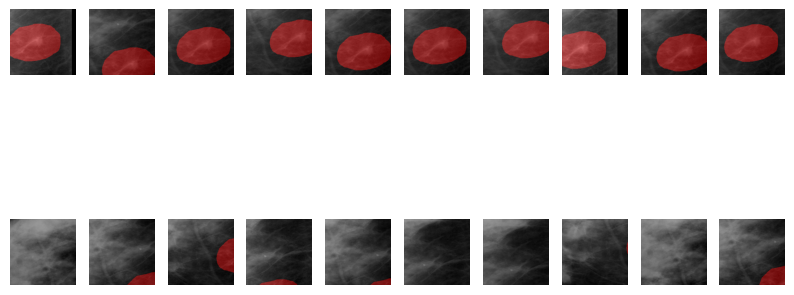

In [55]:
fig, axes = plt.subplots(2, 10, figsize=(10, 5))

for k in range(10):
    show_mask_image(abn_images[k], abn_masks[k], ax=axes[0, k])
    show_mask_image(bkg_images[k], bkg_masks[k], ax=axes[1, k])
 


# Hard negative mining

In [56]:
def extract_hard_negatives_from_anot(annotation, ddsm_root_dir, neg_cutoff=0.2, nb_bkg=50):
    ddsm_root_dir = pathlib.Path(ddsm_root_dir)
    
    image_id = annotation['image_id']
    image_path = ddsm_root_dir / image_id
    img = np.array(Image.open(str(image_path)))
    
    mask_id = annotation['mask_id']
    roi_mask_path = ddsm_root_dir / mask_id
    roi_mask = np.array(Image.open(str(roi_mask_path)))
    
    out_dir = pathlib.Path('/tmp/patches_hard/')
    out_dir.mkdir(exist_ok=True)
    
    bounding_box = annotation['bounding_box'][4:] # x, y, w, h

    
    sample_hard_negatives(img, roi_mask, out_dir, mask_id, bounding_box, patch_size=256,
                neg_cutoff=neg_cutoff,
                nb_bkg=nb_bkg, 
                verbose=True)


In [57]:
root_ddsm = '/home/alalbiol/Data/mamo/DDSM_png_1152x896'
extract_hard_negatives_from_anot(annotations.iloc[0], root_ddsm, neg_cutoff=0.2, nb_bkg=50)

D_4124_1.RIGHT_CC_MASS_MALIGNANT_mask_0_0000_mask.png: sampled a bkg at= (654, 622)
D_4124_1.RIGHT_CC_MASS_MALIGNANT_mask_0_0001_mask.png: sampled a bkg at= (762, 698)
D_4124_1.RIGHT_CC_MASS_MALIGNANT_mask_0_0002_mask.png: sampled a bkg at= (887, 670)
D_4124_1.RIGHT_CC_MASS_MALIGNANT_mask_0_0003_mask.png: sampled a bkg at= (758, 674)
D_4124_1.RIGHT_CC_MASS_MALIGNANT_mask_0_0004_mask.png: sampled a bkg at= (883, 636)
D_4124_1.RIGHT_CC_MASS_MALIGNANT_mask_0_0005_mask.png: sampled a bkg at= (851, 616)
D_4124_1.RIGHT_CC_MASS_MALIGNANT_mask_0_0006_mask.png: sampled a bkg at= (649, 880)
D_4124_1.RIGHT_CC_MASS_MALIGNANT_mask_0_0007_mask.png: sampled a bkg at= (656, 657)
D_4124_1.RIGHT_CC_MASS_MALIGNANT_mask_0_0008_mask.png: sampled a bkg at= (727, 982)
D_4124_1.RIGHT_CC_MASS_MALIGNANT_mask_0_0009_mask.png: sampled a bkg at= (654, 902)
D_4124_1.RIGHT_CC_MASS_MALIGNANT_mask_0_0010_mask.png: sampled a bkg at= (991, 665)
D_4124_1.RIGHT_CC_MASS_MALIGNANT_mask_0_0011_mask.png: sampled a bkg at= (62

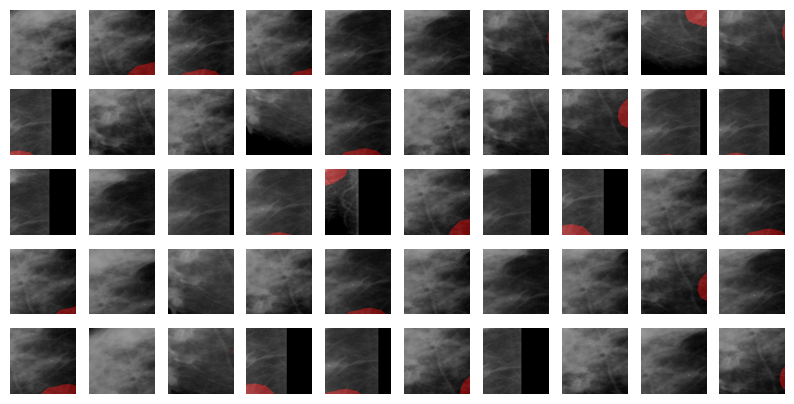

In [58]:
        

bkg_folder = pathlib.Path('/tmp/patches_hard/background/')
images_maks = sorted(list(bkg_folder.glob('*.png')))

bkg_images = images_maks[::2]
bkg_masks = images_maks[1::2]

fig, axes = plt.subplots(5, 10, figsize=(10, 5))

axes = axes.flatten()

for k in range(len(bkg_images)):
    show_mask_image(bkg_images[k], bkg_masks[k], ax=axes[k])
 


# Test patch extractor at blobs

In [59]:
ddsm_root_dir = pathlib.Path('/home/alalbiol/Data/mamo/DDSM_png_1152x896/normals')

normal_imgs = list(ddsm_root_dir.rglob('*.png'))
print("Number of normal images: ", len(normal_imgs))

Number of normal images:  2780


In [60]:
import cv2

def extract_negatives_from_blobs(ddsm_root_dir, neg_cutoff=0.2, nb_bkg=50):
    ddsm_root_dir = pathlib.Path(ddsm_root_dir)
    
    normal_imgs = list(ddsm_root_dir.rglob('*.png'))
    print("Number of normal images: ", len(normal_imgs))
    
    image_path = normal_imgs[0]
    
    img = np.array(Image.open(str(image_path)))
    
    roi_mask = np.zeros_like(img, dtype=np.uint8) 
    
    out_dir = pathlib.Path('/tmp/patches_blob/')
    out_dir.mkdir(exist_ok=True)
    
    
    img_id = image_path.name
    
    blob_min_area=3 
    blob_min_int=.5
    blob_max_int=.85
    blob_th_step=10
    
    roi_size = (256, 256)
    
        # Build a blob detector.
    params = cv2.SimpleBlobDetector_Params()
    params.filterByArea = True
    params.minArea = blob_min_area
    params.maxArea = roi_size[0]*roi_size[1]
    params.filterByCircularity = False
    params.filterByColor = False
    params.filterByConvexity = False
    params.filterByInertia = False
    # blob detection only works with "uint8" images.
    params.minThreshold = int(blob_min_int*255)
    params.maxThreshold = int(blob_max_int*255)
    params.thresholdStep = blob_th_step
    # import pdb; pdb.set_trace()
    ver = (cv2.__version__).split('.')
    if int(ver[0]) < 3:
        blob_detector = cv2.SimpleBlobDetector(params)
    else:
        blob_detector = cv2.SimpleBlobDetector_create(params)


    
    sample_blob_negatives(img, roi_mask, out_dir, img_id, 
                blob_detector, patch_size=256,
                neg_cutoff=neg_cutoff,
                nb_bkg=nb_bkg, 
                verbose=True)


In [61]:
ddsm_root_dir = pathlib.Path('/home/alalbiol/Data/mamo/DDSM_png_1152x896/normals')
extract_negatives_from_blobs(root_ddsm, neg_cutoff=0.2, nb_bkg=50)

Number of normal images:  15084
sampled a blob patch at (954, 161)
sampled a blob patch at (945, 246)
sampled a blob patch at (848, 145)
sampled a blob patch at (835, 151)
sampled a blob patch at (966, 166)
sampled a blob patch at (980, 145)
sampled a blob patch at (781, 823)
sampled a blob patch at (940, 570)
sampled a blob patch at (882, 162)
sampled a blob patch at (272, 252)
sampled a blob patch at (968, 143)
sampled a blob patch at (1011, 182)
sampled a blob patch at (969, 204)
sampled a blob patch at (827, 710)
sampled a blob patch at (841, 164)
sampled a blob patch at (820, 788)
sampled a blob patch at (746, 863)
sampled a blob patch at (780, 747)
sampled a blob patch at (1009, 657)
sampled a blob patch at (754, 853)
sampled a blob patch at (163, 130)
sampled a blob patch at (923, 159)
sampled a blob patch at (932, 151)
sampled a blob patch at (782, 833)
sampled a blob patch at (766, 836)
sampled a blob patch at (999, 152)
sampled a blob patch at (187, 304)
sampled a blob patch 

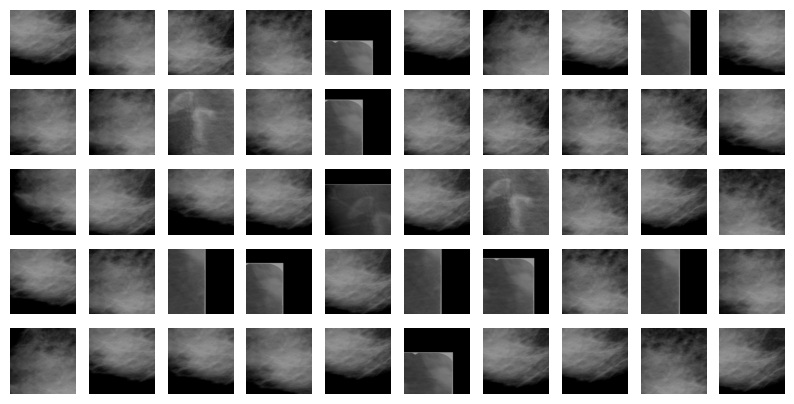

In [65]:
bkg_folder = pathlib.Path('/tmp/patches_blob/background/')

images_maks = sorted(list(bkg_folder.glob('*.png')))

bkg_images = images_maks[::2]
bkg_masks = images_maks[1::2]


fig, axes = plt.subplots(5, 10, figsize=(10, 5))

axes = axes.flatten()

for k in range(50):
    show_mask_image(bkg_images[k], bkg_masks[0], ax=axes[k])


# Test patch extraction for images with several abnormalities